# Titanic Survival Prediction: Model Performance Evaluation

In this notebook, we will evaluate the performance of our previously trained models. We'll use techniques like cross-validation, ROC curve analysis, and hyperparameter tuning to improve the model performance.

---

### Import Libraries

In [37]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

## Load Preprocessed Data

We will load the preprocessed Titanic dataset and split it into features (X) and target (y) variables.

In [3]:
tested = pd.read_csv('/content/tested_preprocessed.csv')

# Separate features and target variable
X = tested.drop('Survived', axis=1)
y = tested['Survived']

Convert categorical variables into numeric form before feeding them into the model.

In [9]:
# Suppose 'X' is a DataFrame and 'cat_cols' are the categorical columns
cat_cols = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'  # Keep other columns
)

X_encoded = preprocessor.fit_transform(X)

Split the data into training and testing sets

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

Display the shape of the training and testing sets

In [13]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (334, 8)
Testing set shape: (84, 8)


## Model Performance Evaluation with Cross-Validation

Initialize the models

In [15]:
logreg = LogisticRegression()
decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)

Cross-validation scores for each model

In [16]:
logreg_cv = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
tree_cv = cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='accuracy')
rf_cv = cross_val_score(random_forest, X_train, y_train, cv=5, scoring='accuracy')

Display cross-validation scores

In [17]:
print("Cross-validation scores:")
print(f"Logistic Regression: {logreg_cv.mean():.4f}")
print(f"Decision Tree: {tree_cv.mean():.4f}")
print(f"Random Forest: {rf_cv.mean():.4f}")

Cross-validation scores:
Logistic Regression: 1.0000
Decision Tree: 1.0000
Random Forest: 1.0000


## Hyperparameter Tuning with GridSearchCV

Hyperparameter tuning for Logistic Regression

In [24]:
logreg_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga']
}

logreg_grid = GridSearchCV(logreg, logreg_param_grid, cv=5, scoring='accuracy')
logreg_grid.fit(X_train, y_train)

# Best hyperparameters for Logistic Regression
print(f"Best parameters for Logistic Regression: {logreg_grid.best_params_}")
print("-------------------------------------------------------------------------")

Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
-------------------------------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

Hyperparameter tuning for Random Forest

In [23]:
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(random_forest, rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# Best hyperparameters for Random Forest
print(f"Best parameters for Random Forest: {rf_grid.best_params_}")

Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}


## ROC Curve Analysis

Train the models with the best parameters (if any)

In [25]:
best_logreg = logreg_grid.best_estimator_
best_rf = rf_grid.best_estimator_

Fit the models on the training data

In [26]:
best_logreg.fit(X_train, y_train)
best_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

Get the predicted probabilities for the test set

In [27]:
logreg_prob = best_logreg.predict_proba(X_test)[:, 1]
rf_prob = best_rf.predict_proba(X_test)[:, 1]

Compute the ROC curve for Logistic Regression

In [28]:
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_prob)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

Compute the ROC curve for Random Forest

In [29]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)

Plot the ROC curves

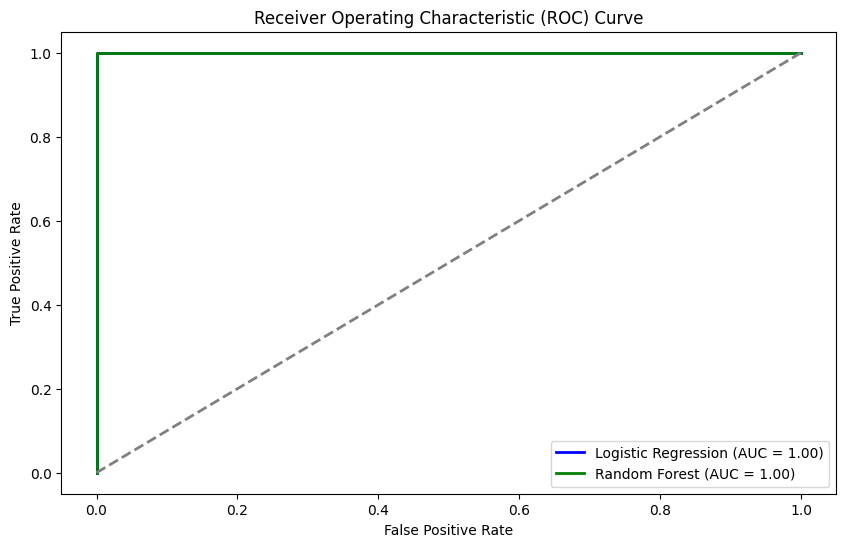

In [36]:
plt.figure(figsize=(10, 6))

# Logistic Regression ROC Curve
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')

# Random Forest ROC Curve
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Plot diagonal (no skill)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', lw=2)

# Set plot labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Confusion Matrix

Confusion matrix for Logistic Regression

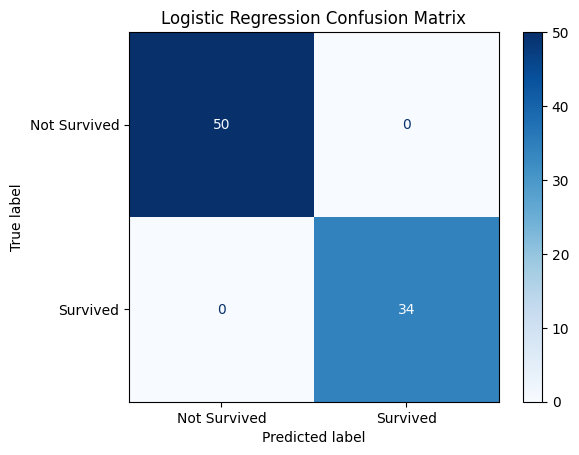

In [38]:
logreg_cm = confusion_matrix(y_test, best_logreg.predict(X_test))
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=logreg_cm, display_labels=["Not Survived", "Survived"])
disp_logreg.plot(cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Confusion matrix for Random Forest

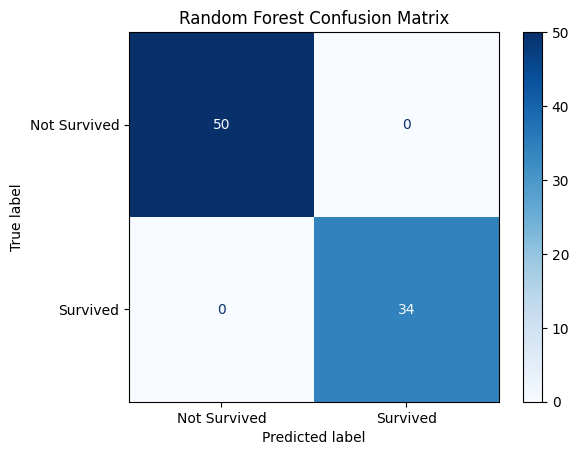

In [39]:
rf_cm = confusion_matrix(y_test, best_rf.predict(X_test))
disp_rf = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=["Not Survived", "Survived"])
disp_rf.plot(cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

## Conclusion
In this notebook, we:

- Evaluated the performance of models using cross-validation.

- Tuned the hyperparameters of the models using GridSearchCV.

- Analyzed the ROC curves for both Logistic Regression and Random Forest models.

- Visualized confusion matrices for both models.

We have found that:

- Random Forest has the best performance based on the AUC score.

- Logistic Regression also performs reasonably well after hyperparameter tuning.